In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unrar x "drive/MyDrive/leafsnap-dataset.rar" "drive/MyDrive/leaf-dataset/"

Streaming output truncated to the last 5000 lines.
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-05-1.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-05-2.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-05-3.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-05-4.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-06-1.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-06-2.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-06-3.jpg      83%  OK 
Extracting  drive/MyDrive/leaf-dataset/leafsnap-dataset/field/quercus_robur/ny1065-06-4.jpg      83%  OK 
Extracting  drive/MyDrive/lea

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential,Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.5.0
Hub version: 0.12.0
GPU available (YESS!!!!)


In [15]:
!pip install split-folders

In [16]:
import splitfolders

In [17]:
input = 'drive/MyDrive/leaf-dataset/leafsnap-dataset/field/'
output = 'drive/MyDrive/leaves-dataset'
splitfolders.ratio(input,output,seed = 44, ratio = (0.7,0.3))

Copying files: 30221 files [06:07, 82.24 files/s]


In [53]:
img_width, img_height = (224,224)
batch_size =32
train_data_directory = "drive/MyDrive/leaves-dataset/train/"
val_data_directory = "drive/MyDrive/leaves-dataset/val"

In [54]:
names = []
images = []
for i in os.listdir(train_data_directory):
    for image_filename in os.listdir(train_data_directory + i):
        names.append(i) # name
        images.append(i + '/' + image_filename) # image

In [55]:
train_pics = pd.DataFrame({'Labels':names,'Images':images})
train_pics

Labels                              Images
0       abies_concolor   abies_concolor/12995309745356.jpg
1       abies_concolor      abies_concolor/ny1178-07-1.jpg
2       abies_concolor      abies_concolor/ny1179-02-3.jpg
3       abies_concolor      abies_concolor/ny1179-07-3.jpg
4       abies_concolor      abies_concolor/ny1157-23-2.jpg
...                ...                                 ...
21063  zelkova_serrata  zelkova_serrata/12992008471153.jpg
21064  zelkova_serrata     zelkova_serrata/ny1009-02-3.jpg
21065  zelkova_serrata     zelkova_serrata/ny1007-10-4.jpg
21066  zelkova_serrata     zelkova_serrata/ny1007-04-1.jpg
21067  zelkova_serrata     zelkova_serrata/ny1008-04-2.jpg

[21068 rows x 2 columns]

In [56]:
print(train_pics.describe())
print(train_pics.head())

                  Labels                                  Images
count              21068                                   21068
unique               185                                   21068
top     maclura_pomifera  amelanchier_arborea/13291782505662.jpg
freq                 313                                       1
           Labels                             Images
0  abies_concolor  abies_concolor/12995309745356.jpg
1  abies_concolor     abies_concolor/ny1178-07-1.jpg
2  abies_concolor     abies_concolor/ny1179-02-3.jpg
3  abies_concolor     abies_concolor/ny1179-07-3.jpg
4  abies_concolor     abies_concolor/ny1157-23-2.jpg


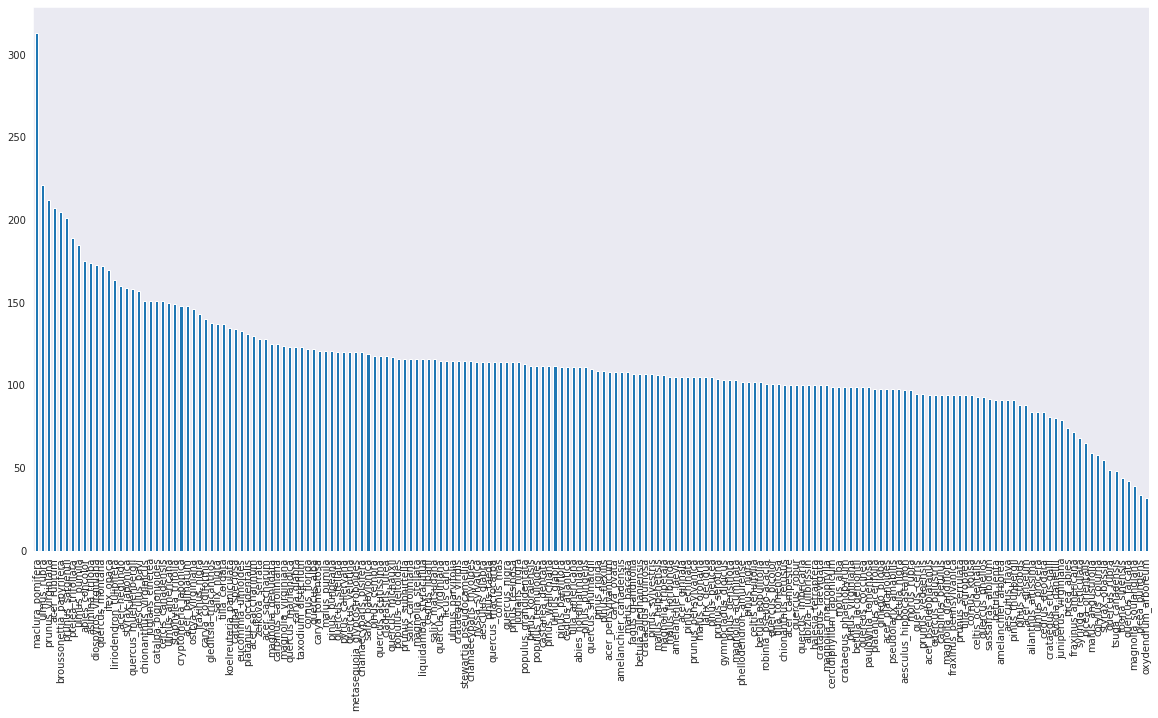

In [57]:
# How many images are there of each catagory?
train_pics["Labels"].value_counts().plot.bar(figsize=(20, 10));

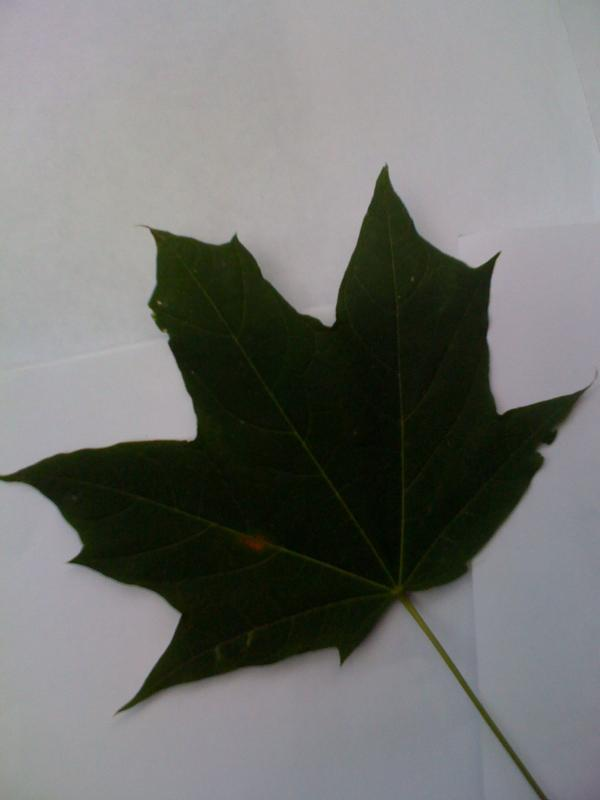

In [58]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/leaf-dataset/leafsnap-dataset/field/acer_platanoides/1249316899_0002.jpg")

In [59]:
from collections import Counter
newData = Counter(train_pics["Labels"])
most_pics = newData.most_common(15)

print("The 15 most frequently found leaves in the data set and their number")
most_pics

The 15 most frequently found leaves in the data set and their number


[('maclura_pomifera', 313),
 ('ulmus_rubra', 221),
 ('prunus_virginiana', 212),
 ('acer_rubrum', 207),
 ('broussonettia_papyrifera', 205),
 ('prunus_sargentii', 201),
 ('ptelea_trifoliata', 189),
 ('ulmus_pumila', 185),
 ('abies_concolor', 175),
 ('asimina_triloba', 174),
 ('diospyros_virginiana', 173),
 ('quercus_montana', 172),
 ('ilex_opaca', 170),
 ('liriodendron_tulipifera', 164),
 ('acer_negundo', 160)]

In [60]:
x,y = zip(*most_pics)
x,y = list(x),list(y)

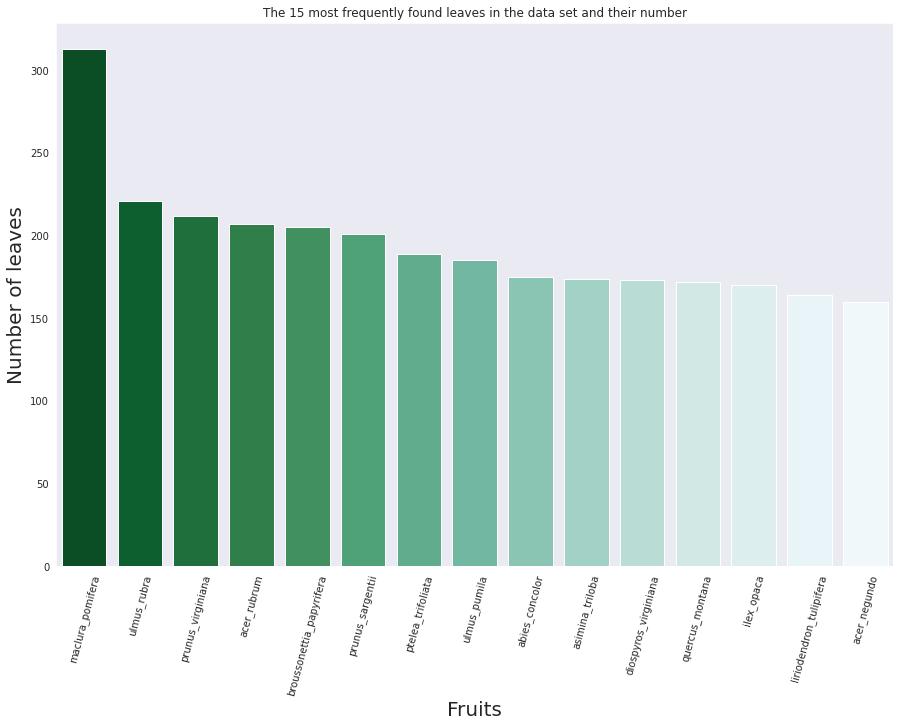

In [109]:
plt.figure(figsize=(15,10))
ax= sns.barplot(x=x, y=y, palette=sns.color_palette("BuGn_r", 15)) 
plt.xlabel('Fruits', size = 20) 
plt.ylabel('Number of leaves', size = 20 )
plt.xticks(rotation = 75)
plt.title('The 15 most frequently found leaves in the data set and their number') 
plt.show()

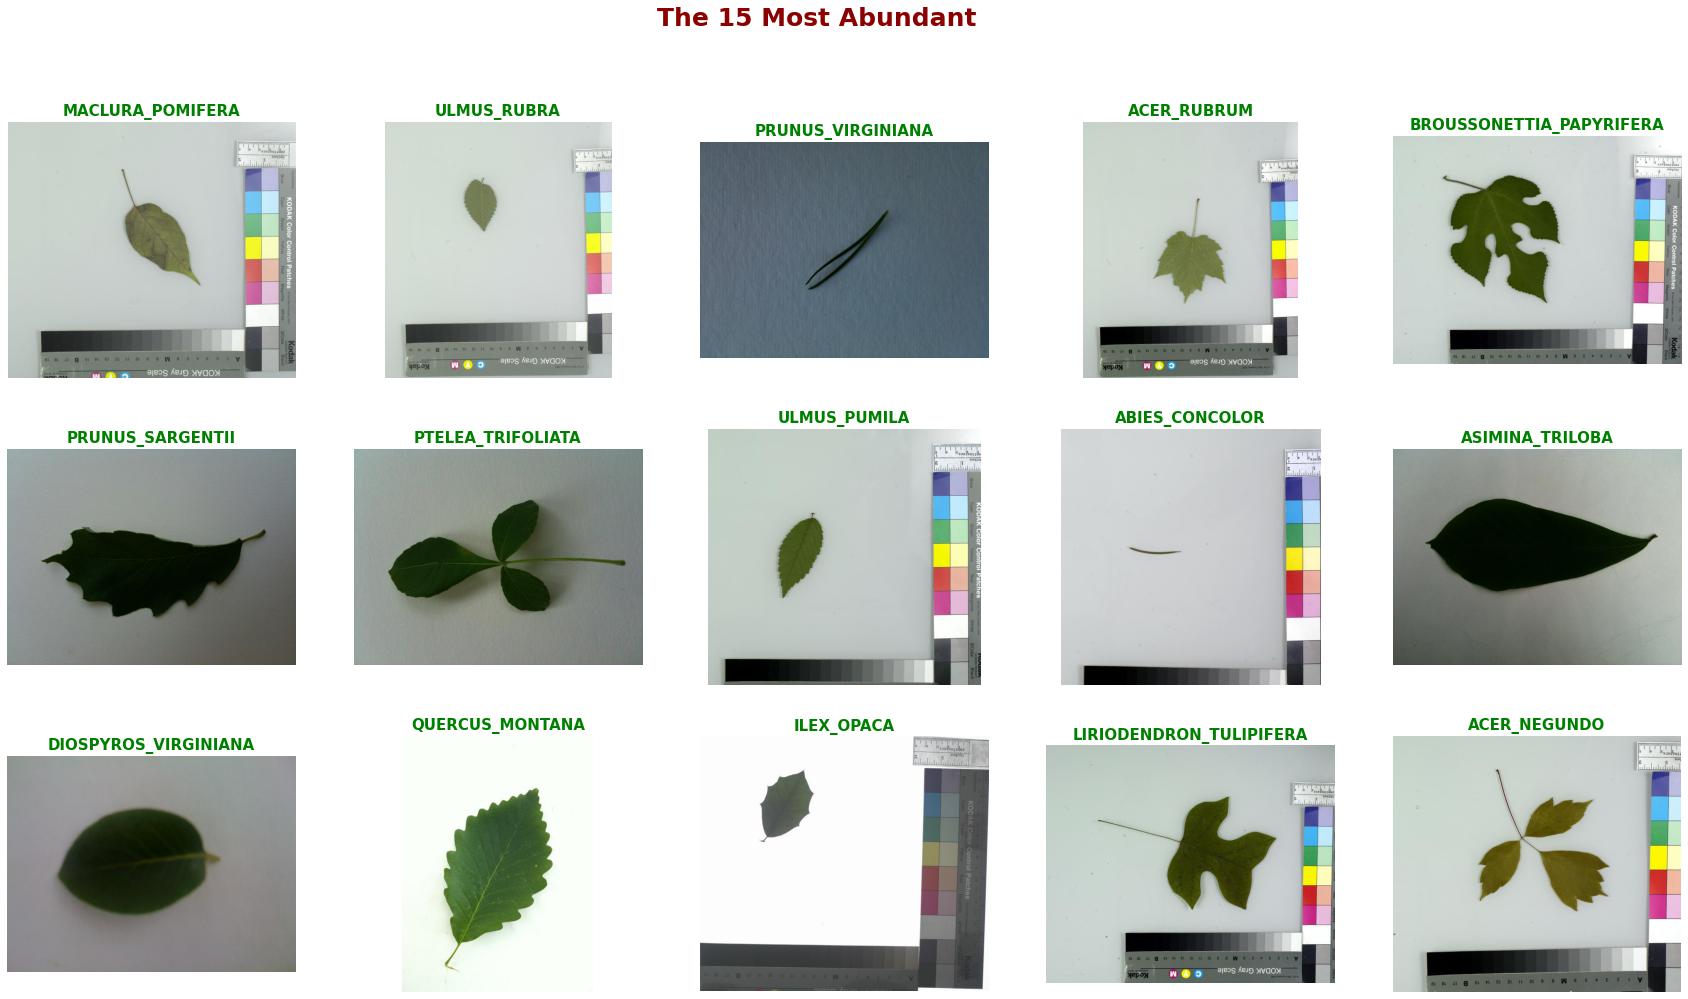

In [62]:
plt.figure(figsize=(30,16))
how_many_pics = len(x)

for i in range(how_many_pics):
    names = train_pics[train_pics["Labels"] == x[i]]["Images"].values [1]
    
    plt.subplot(3,5,i+1)
    img = load_img(train_data_directory + names)
    plt.imshow(img)
    plt.title(x[i].upper(), color = "green", fontsize = 15 , fontweight = 600)
    plt.axis("off")

plt.suptitle("The 15 Most Abundant", fontsize = 25 , color = "darkred", fontweight = 'bold')
plt.show()

In [63]:
datagen = ImageDataGenerator(rescale=1./255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True, fill_mode='nearest')
train_generator = datagen.flow_from_directory(train_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    shuffle = True,
                                                    batch_size=batch_size,)
val_generator = datagen.flow_from_directory(val_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size,shuffle = False)

Found 21068 images belonging to 185 classes.
Found 9153 images belonging to 185 classes.


In [32]:
print(train_generator.class_indices)

unique_labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('drive/MyDrive/labels/leaves_labels.txt','w') as f:
  f.write(unique_labels)

{'abies_concolor': 0, 'abies_nordmanniana': 1, 'acer_campestre': 2, 'acer_ginnala': 3, 'acer_griseum': 4, 'acer_negundo': 5, 'acer_palmatum': 6, 'acer_pensylvanicum': 7, 'acer_platanoides': 8, 'acer_pseudoplatanus': 9, 'acer_rubrum': 10, 'acer_saccharinum': 11, 'acer_saccharum': 12, 'aesculus_flava': 13, 'aesculus_glabra': 14, 'aesculus_hippocastamon': 15, 'aesculus_pavi': 16, 'ailanthus_altissima': 17, 'albizia_julibrissin': 18, 'amelanchier_arborea': 19, 'amelanchier_canadensis': 20, 'amelanchier_laevis': 21, 'asimina_triloba': 22, 'betula_alleghaniensis': 23, 'betula_jacqemontii': 24, 'betula_lenta': 25, 'betula_nigra': 26, 'betula_populifolia': 27, 'broussonettia_papyrifera': 28, 'carpinus_betulus': 29, 'carpinus_caroliniana': 30, 'carya_cordiformis': 31, 'carya_glabra': 32, 'carya_ovata': 33, 'carya_tomentosa': 34, 'castanea_dentata': 35, 'catalpa_bignonioides': 36, 'catalpa_speciosa': 37, 'cedrus_atlantica': 38, 'cedrus_deodara': 39, 'cedrus_libani': 40, 'celtis_occidentalis': 41

In [33]:
unique_labels = unique_labels.split('\n')

In [ ]:
# test_generator = datagen.flow_from_directory(test_data_directory, 
#                                                     target_size=(img_width, img_height), 
#                                                     class_mode='categorical',shuffle=False, 
#                                                     batch_size=1)

Found 10885 images belonging to 38 classes.


In [64]:
INPUT_SHAPE = [None, img_height, img_width, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = train_generator.num_classes

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"

In [65]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [66]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              2555993   
_________________________________________________________________
dense_2 (Dense)              (None, 185)               185370    
Total params: 2,741,363
Trainable params: 185,370
Non-trainable params: 2,555,993
_________________________________________________________________


In [67]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [69]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Data/leaves_logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [70]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2)

In [71]:
NUM_EPOCHS = 5 #@param {type:"slider", min:5, max:100, step:5}

In [72]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_generator,
            epochs=NUM_EPOCHS,
            validation_data=val_generator,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [73]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [74]:
#Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5
Epoch 1/5
659/659 [==============================] - 460s 693ms/step - loss: 2.0900 - accuracy: 0.5072 - val_loss: 1.1307 - val_accuracy: 0.6816
Epoch 2/5
659/659 [==============================] - 440s 669ms/step - loss: 0.8510 - accuracy: 0.7539 - val_loss: 0.8748 - val_accuracy: 0.7540
Epoch 3/5
659/659 [==============================] - 440s 668ms/step - loss: 0.6301 - accuracy: 0.8137 - val_loss: 0.7579 - val_accuracy: 0.7851
Epoch 4/5
659/659 [==============================] - 440s 668ms/step - loss: 0.5315 - accuracy: 0.8380 - val_loss: 0.6641 - val_accuracy: 0.8042
Epoch 5/5
659/659 [==============================] - 439s 667ms/step - loss: 0.4572 - accuracy: 0.8587 - val_loss: 0.6530 - val_accuracy: 0.8153


In [75]:
val_loss, val_acc = model.evaluate(val_generator)

287/287 [==============================] - 133s 465ms/step - loss: 0.6614 - accuracy: 0.8090


In [76]:
Y_pred = model.predict(val_generator)
Y_pred = np.argmax(Y_pred, axis=1)
val_labels = val_generator.classes

In [77]:
class_names = os.listdir(train_data_directory)

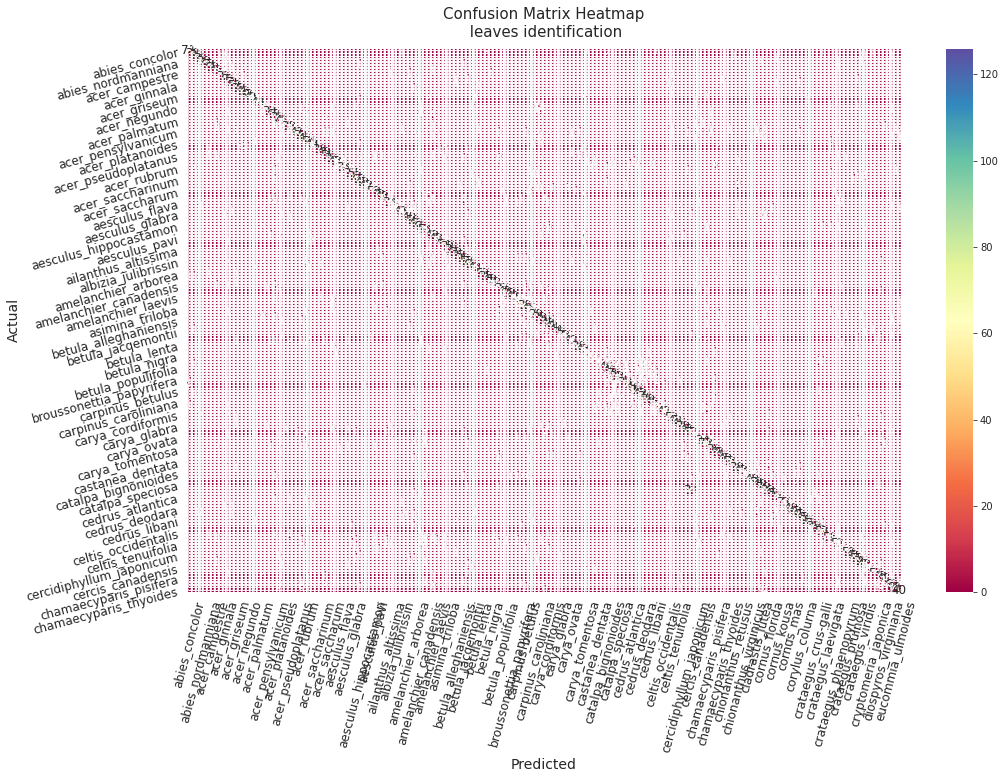

In [79]:
conf_mat = confusion_matrix(val_labels,Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":12},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n leaves identification', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(class_names, fontdict={'fontsize':12,'rotation': 75})
heatmap.set_yticklabels(class_names, fontdict={'fontsize':12,'rotation': 15})
plt.show()

In [80]:
predictions = model.predict(val_generator)

In [81]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[79])
pred_label

'abies_nordmanniana'

In [101]:
import matplotlib.image as mpimg
filenames_n = ['drive/MyDrive/leaves-dataset/val/' + fname for fname in val_generator.filenames]

In [83]:
labels = val_generator.classes
true_labels = [unique_labels[i] for i in labels]


In [102]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(mpimg.imread(image))
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

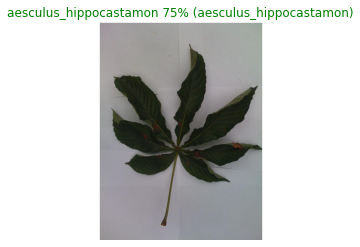

In [104]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=true_labels,
          images=filenames_n,n = 809)

In [105]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  # top_10_pred_labels = map(unique_labels.__getitem__, top_10_pred_indexes)
  # top_10_pred_labels = unique_labels[top_10_pred_indexes]
  top_10_pred_labels= [unique_labels[i] for i in top_10_pred_indexes]
  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

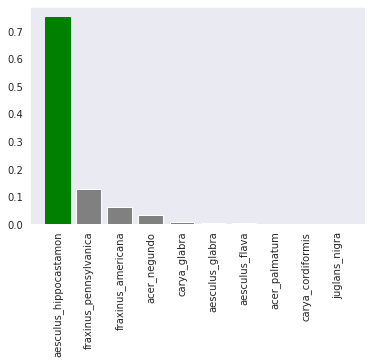

In [106]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=true_labels,
               n=809)

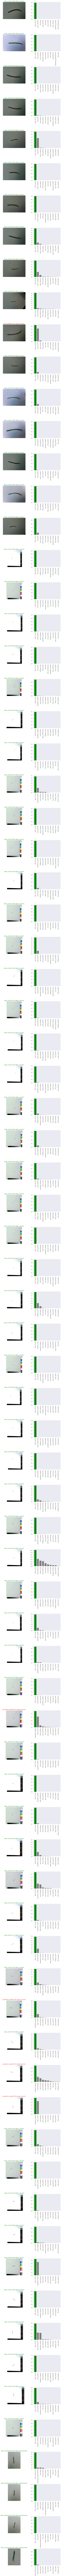

In [107]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 80
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=true_labels,
            images=filenames_n,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=true_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [86]:
saved_model_dir = ''
tf.saved_model.save(model,saved_model_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('drive/MyDrive/tflite_models/leaves_model_batch32_highest.tflite', 'wb') as f:
  f.write(tflite_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


In [87]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/tf_models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [88]:
# Save our model trained on whole images
save_model(model, suffix="leaves-identification-mobilenet_v3_small_100_224_batch32_highest")

Saving model to: drive/MyDrive/tf_models/20210530-16161622391372-leaves-identification-mobilenet_v3_small_100_224_batch32_highest.h5...


'drive/MyDrive/tf_models/20210530-16161622391372-leaves-identification-mobilenet_v3_small_100_224_batch32_highest.h5'

In [90]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [91]:
model = load_model('/content/drive/MyDrive/tf_models/20210530-16161622391372-leaves-identification-mobilenet_v3_small_100_224_batch32_highest.h5')

Loading saved model from: /content/drive/MyDrive/tf_models/20210530-16161622391372-leaves-identification-mobilenet_v3_small_100_224_batch32_highest.h5


In [94]:
labels = ['abies_concolor', 'abies_nordmanniana', 'acer_campestre', 'acer_ginnala', 'acer_griseum', 'acer_negundo', 'acer_palmatum', 'acer_pensylvanicum', 'acer_platanoides', 'acer_pseudoplatanus', 'acer_rubrum', 'acer_saccharinum', 'acer_saccharum', 'aesculus_flava', 'aesculus_glabra', 'aesculus_hippocastamon', 'aesculus_pavi', 'ailanthus_altissima', 'albizia_julibrissin', 'amelanchier_arborea', 'amelanchier_canadensis', 'amelanchier_laevis', 'asimina_triloba', 'betula_alleghaniensis', 'betula_jacqemontii', 'betula_lenta', 'betula_nigra', 'betula_populifolia', 'broussonettia_papyrifera', 'carpinus_betulus', 'carpinus_caroliniana', 'carya_cordiformis', 'carya_glabra', 'carya_ovata', 'carya_tomentosa', 'castanea_dentata', 'catalpa_bignonioides', 'catalpa_speciosa', 'cedrus_atlantica', 'cedrus_deodara', 'cedrus_libani', 'celtis_occidentalis', 'celtis_tenuifolia', 'cercidiphyllum_japonicum', 'cercis_canadensis', 'chamaecyparis_pisifera', 'chamaecyparis_thyoides', 'chionanthus_retusus', 'chionanthus_virginicus', 'cladrastis_lutea', 'cornus_florida', 'cornus_kousa', 'cornus_mas', 'corylus_colurna', 'crataegus_crus-galli', 'crataegus_laevigata', 'crataegus_phaenopyrum', 'crataegus_pruinosa', 'crataegus_viridis', 'cryptomeria_japonica', 'diospyros_virginiana', 'eucommia_ulmoides', 'evodia_daniellii', 'fagus_grandifolia', 'ficus_carica', 'fraxinus_americana', 'fraxinus_nigra', 'fraxinus_pennsylvanica', 'ginkgo_biloba', 'gleditsia_triacanthos', 'gymnocladus_dioicus', 'halesia_tetraptera', 'ilex_opaca', 'juglans_cinerea', 'juglans_nigra', 'juniperus_virginiana', 'koelreuteria_paniculata', 'larix_decidua', 'liquidambar_styraciflua', 'liriodendron_tulipifera', 'maclura_pomifera', 'magnolia_acuminata', 'magnolia_denudata', 'magnolia_grandiflora', 'magnolia_macrophylla', 'magnolia_soulangiana', 'magnolia_stellata', 'magnolia_tripetala', 'magnolia_virginiana', 'malus_angustifolia', 'malus_baccata', 'malus_coronaria', 'malus_floribunda', 'malus_hupehensis', 'malus_pumila', 'metasequoia_glyptostroboides', 'morus_alba', 'morus_rubra', 'nyssa_sylvatica', 'ostrya_virginiana', 'oxydendrum_arboreum', 'paulownia_tomentosa', 'phellodendron_amurense', 'picea_abies', 'picea_orientalis', 'picea_pungens', 'pinus_bungeana', 'pinus_cembra', 'pinus_densiflora', 'pinus_echinata', 'pinus_flexilis', 'pinus_koraiensis', 'pinus_nigra', 'pinus_parviflora', 'pinus_peucea', 'pinus_pungens', 'pinus_resinosa', 'pinus_rigida', 'pinus_strobus', 'pinus_sylvestris', 'pinus_taeda', 'pinus_thunbergii', 'pinus_virginiana', 'pinus_wallichiana', 'platanus_acerifolia', 'platanus_occidentalis', 'populus_deltoides', 'populus_grandidentata', 'populus_tremuloides', 'prunus_pensylvanica', 'prunus_sargentii', 'prunus_serotina', 'prunus_serrulata', 'prunus_subhirtella', 'prunus_virginiana', 'prunus_yedoensis', 'pseudolarix_amabilis', 'ptelea_trifoliata', 'pyrus_calleryana', 'quercus_acutissima', 'quercus_alba', 'quercus_bicolor', 'quercus_cerris', 'quercus_coccinea', 'quercus_falcata', 'quercus_imbricaria', 'quercus_macrocarpa', 'quercus_marilandica', 'quercus_michauxii', 'quercus_montana', 'quercus_muehlenbergii', 'quercus_nigra', 'quercus_palustris', 'quercus_phellos', 'quercus_robur', 'quercus_rubra', 'quercus_shumardii', 'quercus_stellata', 'quercus_velutina', 'quercus_virginiana', 'robinia_pseudo-acacia', 'salix_babylonica', 'salix_caroliniana', 'salix_matsudana', 'salix_nigra', 'sassafras_albidum', 'staphylea_trifolia', 'stewartia_pseudocamellia', 'styrax_japonica', 'styrax_obassia', 'syringa_reticulata', 'taxodium_distichum', 'tilia_americana', 'tilia_cordata', 'tilia_europaea', 'tilia_tomentosa', 'toona_sinensis', 'tsuga_canadensis', 'ulmus_americana', 'ulmus_glabra', 'ulmus_parvifolia', 'ulmus_procera', 'ulmus_pumila', 'ulmus_rubra', 'zelkova_serrata']

acer_negundo


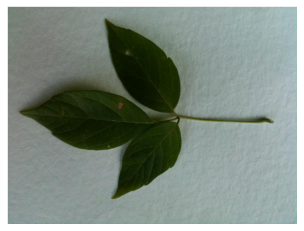

In [108]:
import os
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path = '/content/drive/MyDrive/leaf-dataset/leafsnap-dataset/field/acer_negundo/13001151161760.jpg'
    # load a single image
    new_image = load_image(img_path)
    import matplotlib.image as mpimg
    plt.imshow(mpimg.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    # check prediction
    pred = model.predict(new_image)
    print(labels[pred.argmax()])